# LLaMA 3.1 8B Instruct Notebook

This notebook contains the setup and evaluation of the LLaMA 3.1 8B Instruct model for zero-shot music genre classification using song lyrics.

It includes:
- Prompt design

- Optional metadata integration (release year and danceability)

- Generation of predictions

- Performance evaluation using classification report and confusion matrix.

The results are stored to `run_results/results/llama`

<br>
The code is inspired from:

- [LLaMA 3 Model](https://huggingface.co/meta-llama/Llama-3-8b-Instruct)

- [HuggingFace Generation Strategies](https://huggingface.co/docs/transformers/en/generation_strategies)

- [HuggingFace pipeline](https://huggingface.co/docs/transformers/pipeline_tutorial)

- [Prompt Engineering Guide](https://github.com/dair-ai/Prompt-Engineering-Guide)

- [Lecture code](http://colab.research.google.com/drive/1wx2WV_jEm-DIO7h8tQfrzOk62u9tQT32#scrollTo=aG1LPt4mbWcl)

- [Lecture code](https://colab.research.google.com/drive/1hbyGBP71kbcIGR-XvqLs3HsXc8okbDBK?usp=sharing)

- [ChatGPT](https://chatgpt.com/)


Training was conducted on Google Colab

In [ ]:
try:
    # Comment out if not using colab
    from google.colab import drive
    drive.mount('/content/drive')

    %cd "/content/drive/Othercomputers/Min MacBook Pro/semester_project_info371"
    #using_colab = True
except:
    print("Not using Google Colab")
    #using_colab = False

Mounted at /content/drive
/content/drive/Othercomputers/Min MacBook Pro/semester_project_info371


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from google.colab import userdata
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import os
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Importing local functions
from train_eval_utils import save_test_results

## Loading dataset

In [ ]:
df_train = pd.read_csv("music_dataset_split/Train/training_data.csv")
df_test = pd.read_csv("music_dataset_split/Test/test_data.csv")


In [ ]:
df_train.head(5)

,id,release_date,genre,lyrics,danceability
0,27780,2012,hip hop,wanna sound wanna sound feel marvelous right d...,0.541861
1,25749,1997,rock,time time time time time honk horn fuck fuck f...,0.753060
2,22028,1997,reggae,play game long start believe doubt try convinc...,0.710820
3,20445,2013,jazz,stop love mind live memories lonesome time sto...,0.596014
4,4885,2001,pop,people wanna kick nerd grow suburbs go wrong s...,0.463880


In [ ]:
df_test['genre'].value_counts()

,count
genre,
pop,1044
country,810
blues,676
rock,592
jazz,553
reggae,371
hip hop,135


In [ ]:
df_train['genre'] = df_train['genre'].str.strip().str.lower().replace("hip hop", "hip-hop")
df_test['genre'] = df_test['genre'].str.strip().str.lower().replace("hip hop", "hip-hop")
print(df_train['genre'].value_counts())
print(df_test['genre'].value_counts())

genre
pop        4870
country    3780
blues      3152
rock       2766
jazz       2582
reggae     1730
hip-hop     630
Name: count, dtype: int64
genre
pop        1044
country     810
blues       676
rock        592
jazz        553
reggae      371
hip-hop     135
Name: count, dtype: int64


# Llama 3.1

**Model Setup**

In [ ]:
model_name = "meta-llama/Llama-3.1-8B-Instruct"
access_token = userdata.get('HF_TOKEN')

**Load tokenizer and base model (for logits)**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
model = AutoModelForCausalLM.from_pretrained(model_name, token=access_token, torch_dtype=torch.float16)

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

**Load text-generation pipeline (for human-readable output)**

In [ ]:
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    token=access_token
)


Device set to use cuda:0


In [ ]:
genres = sorted(df_train['genre'].unique())
genre_token_ids = {
    genre: tokenizer(f" {genre}", add_special_tokens=False)['input_ids'][0]
    for genre in genres
}

**Build zero-shot prompt from lyrics**

In [ ]:
def build_prompt(lyrics):
    return f"""
            You are a music genre classification expert.

            Classify the genre of the following lyrics.

            Lyrics: "{lyrics}"

            Options: {", ".join(genres)}

            Answer just the genre you classify it as. I dont want any explination. Answer: genre.\n\n
            Answer:"""

**Build zero-shot prompt with Lyrics + release year**


In [ ]:
def build_prompt_year(lyrics, year):
    prompt = "You are a music genre classification expert.\n\n"
    prompt += "Note: The following lyrics have been heavly preprocessed.\n\n"

    prompt += (
        "The year a song was released can influence its genre. "
        "Different genres were more popular in different time periods.\n\n"
    )
    prompt += "Classify the genre of the following lyrics.\n\n"

    prompt += f'Lyrics: "{lyrics}", Published year: {year}\n'
    prompt += f'Answer just the genre you classify it as. I dont want any explination. Answer: genre.\n\n'

    prompt += f'The only options are: {", ".join(genres)}\n'
    prompt += "Answer:"
    return prompt


**Build zero-shot prompt with Lyrics + danceability**

In [ ]:
def build_prompt_danceability(lyrics, danceability):
    prompt = "You are a music genre classification expert.\n\n"
    prompt += "Note: The following lyrics have been heavily preprocessed.\n\n"

    prompt += (
        "Danceability indicates how suitable a song is for dancing, based on musical elements like tempo, rhythm stability, beat strength, "
        "and overall regularity. Higher values suggest better suitability for dancing.\n\n"
    )
    prompt += "Classify the genre of the following lyrics, taking into account its danceability score.\n\n"

    prompt += f'Lyrics: "{lyrics}", Danceability Score: {danceability:.3f}\n'
    prompt += f'Answer just the genre you classify it as. I don’t want any explanation. Answer: genre.\n\n'

    prompt += f'The only options are: {", ".join(genres)}\n'
    prompt += "Answer:"
    return prompt


**Build prompt with Lyrics + year and dancability**

In [ ]:
def build_prompt_year_dance(lyrics, year, danceability):
    prompt = "You are a music genre classification expert.\n\n"
    prompt += "Note: The following lyrics have been heavly preprocessed.\n\n"

    prompt += (
        "The year a song was released can influence its genre. "
        "Different genres were more popular in different time periods.\n\n"
    )
    prompt += (
        "Danceability indicates how suitable a song is for dancing, based on musical elements like tempo, rhythm stability, beat strength, "
        "and overall regularity. Higher values suggest better suitability for dancing.\n\n"
    )
    prompt += "Classify the genre of the following lyrics.\n\n"

    prompt += f'Lyrics: "{lyrics}", Published year: {year}, Danceability Score: {danceability:.3f}\n'
    prompt += f'Answer just the genre you classify it as. I dont want any explination. Answer: genre.\n\n'

    prompt += f'The only options are: {", ".join(genres)}\n'
    prompt += "Answer:"
    return prompt

**Generate model's text response**

In [ ]:
def generate_response(prompt):
    return generator(
            prompt,
            max_new_tokens=1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
            )[0]['generated_text']

**Classifying the lyrics**

In [ ]:
def classify_lyrics(lyrics, true_genre=None, show_output=True, year=None, dance=None):

    if year is not None and dance is not None:
        prompt = build_prompt_year_dance(lyrics, year, dance)
    elif year is not None:
        prompt = build_prompt_year(lyrics, year)
    elif dance is not None:
        prompt = build_prompt_danceability(lyrics, dance)
    else:
        prompt = build_prompt(lyrics)

    # Generate model's output
    gen_output = generate_response(prompt)

    # Extract model's predicted answer
    try:
        predicted_genre = gen_output.split('Answer:')[-1].strip().split()[0].lower()
        if predicted_genre == 'hip':
            predicted_genre = 'hip-hop'
    except:
        predicted_genre = "unknown"

    # Print output if desired
    if show_output:
        print(f"\nLyrics (excerpt): {lyrics[:100]}...")
        if true_genre:
            print(f"True Genre       : {true_genre}")
        print(f"Model Says       : {gen_output.strip()}")
        print(f"Predicted Genre  : {predicted_genre}")
        print("-" * 50)

    return {
        "lyrics": lyrics,
        "true_genre": true_genre,
        "predicted_genre": predicted_genre,
        "prompt_used": prompt,
        "gen_output": gen_output.strip()
    }


### **Test call**

Test call on zero-shot with Lyrics

In [ ]:
result_zero_shot = classify_lyrics(
    lyrics=df_train.iloc[-1]['lyrics'],
    true_genre=df_train.iloc[-1]['genre'],
    show_output=True,
    year=None,
    dance=None
)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(



Lyrics (excerpt): country girl shake hips ddddj record straight redneck rager body shots yager moonshine sippin bacard...
True Genre       : country
Model Says       : You are a music genre classification expert.

            Classify the genre of the following lyrics.

            Lyrics: "country girl shake hips ddddj record straight redneck rager body shots yager moonshine sippin bacardi showin vegas country folk party happen backwoods stay backwoods goin hard mother crank crank woot woot party woot woot dancin girl flatbed hotter marlboro weekend come crank crank woot woot crank crank crank woot woot crank beat acdc repeat woot woot shake night long popo come know roll deep know gettin start showin vegas country folks party happen backwoods stay backwoods goin hard mother crank crank woot woot party woot woot dancin girl flatbed hotter marlboro weekend come crank crank crank crank crank crank woot woot party woot woot bust scoot little closer right turn cornfield club crank crank 

Test call on zero-shot with Lyrics + year

In [ ]:
result_zero_shot = classify_lyrics(
    lyrics=df_train.iloc[-1]['lyrics'],
    true_genre=df_train.iloc[-1]['genre'],
    show_output=True,
    year=df_train.iloc[-1]['release_date'],
    dance=None
)


Lyrics (excerpt): country girl shake hips ddddj record straight redneck rager body shots yager moonshine sippin bacard...
True Genre       : country
Model Says       : You are a music genre classification expert.

Note: The following lyrics have been heavly preprocessed.

The year a song was released can influence its genre. Different genres were more popular in different time periods.

Classify the genre of the following lyrics.

Lyrics: "country girl shake hips ddddj record straight redneck rager body shots yager moonshine sippin bacardi showin vegas country folk party happen backwoods stay backwoods goin hard mother crank crank woot woot party woot woot dancin girl flatbed hotter marlboro weekend come crank crank woot woot crank crank crank woot woot crank beat acdc repeat woot woot shake night long popo come know roll deep know gettin start showin vegas country folks party happen backwoods stay backwoods goin hard mother crank crank woot woot party woot woot dancin girl flatbed ho

Test call on zero-shot with Lyrics + dancability

In [ ]:
result_zero_shot = classify_lyrics(
    lyrics=df_train.iloc[1000]['lyrics'],
    true_genre=df_train.iloc[1000]['genre'],
    show_output=True,
    year=None,
    dance=df_train.iloc[-1]['danceability']
)


Lyrics (excerpt): repel pride material hype deep earth dirt collide save life heaven send know everybody wish bear say...
True Genre       : reggae
Model Says       : You are a music genre classification expert.

Note: The following lyrics have been heavily preprocessed.

Danceability indicates how suitable a song is for dancing, based on musical elements like tempo, rhythm stability, beat strength, and overall regularity. Higher values suggest better suitability for dancing.

Classify the genre of the following lyrics, taking into account its danceability score.

Lyrics: "repel pride material hype deep earth dirt collide save life heaven send know everybody wish bear say line heart star forget speak earth rotation vibe seek good vibration ooooh ooooh want good vibration want like like salvation want good want live good life wanna want good vibe good vibe good vibe good vibe good vibe good vibe good vibe good vibe good vibe good vibe hear hear sound unini niverse feel raise ash come l

Test call on zero-shot with Lyrics + year and dancability

In [ ]:
result_zero_shot = classify_lyrics(
    lyrics=df_train.iloc[-1]['lyrics'],
    true_genre=df_train.iloc[-1]['genre'],
    show_output=True,
    year=df_train.iloc[-1]['release_date'],
    dance=df_train.iloc[-1]['danceability']
)


Lyrics (excerpt): country girl shake hips ddddj record straight redneck rager body shots yager moonshine sippin bacard...
True Genre       : country
Model Says       : You are a music genre classification expert.

Note: The following lyrics have been heavly preprocessed.

The year a song was released can influence its genre. Different genres were more popular in different time periods.

Danceability indicates how suitable a song is for dancing, based on musical elements like tempo, rhythm stability, beat strength, and overall regularity. Higher values suggest better suitability for dancing.

Classify the genre of the following lyrics.

Lyrics: "country girl shake hips ddddj record straight redneck rager body shots yager moonshine sippin bacardi showin vegas country folk party happen backwoods stay backwoods goin hard mother crank crank woot woot party woot woot dancin girl flatbed hotter marlboro weekend come crank crank woot woot crank crank crank woot woot crank beat acdc repeat woo

### **Loop Through Multiple Songs**

In [ ]:
def classify_lyrics_bulk(song_bulk, show_output = False, year = None, dance = None, description= ""):
    results = []

    for i in tqdm(range(len(song_bulk)), desc= f"{description} Prompting"):
        row = song_bulk.iloc[i]
        if year:
            year = row['release_date']
        if dance:
            dance = row['danceability']

        result = classify_lyrics(
            lyrics=row['lyrics'],
            true_genre=row['genre'],
            show_output = show_output,
            year = year,
            dance = dance
        )
        results.append(result)

    return results


**Visualiztion Function**

In [ ]:
def evaluate_genre_predictions(true_labels, predicted_labels, folder, file_name, labels=None, description = ""):

    # If no specific label list provided, get from unique labels
    if labels is None:
        labels = sorted(set(true_labels + predicted_labels))

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

    # Classification Report
    print("Classification Report:\n")
    report = classification_report(true_labels, predicted_labels, labels=labels, digits=2)
    print(report)

    # Save results to a file
    save_test_results(
        folder=folder,
        file_name=file_name,
        accuracy=accuracy,
        classification_rep=report,
        confusion_matrix_data=cm,
        label_encoder=labels
    )

    # Plot with seaborn
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {description} LLaMA 3.1")
    plt.tight_layout()
    plt.show()


## Testing on the same test set as the DistilBERT and BERT


**Testset on zero-shot with Lyrics**

In [ ]:
results_zero_test = classify_lyrics_bulk(
    song_bulk=df_test,
    show_output=False,
    dance=None,
    year=None,
    description="Test Evaluation - Lyrics"
)

Test Evaluation - Lyrics Prompting: 100%|██████████| 4181/4181 [06:52<00:00, 10.13it/s]



Test Accuracy: 0.1217
Classification Report:

              precision    recall  f1-score   support

       blues       0.30      0.03      0.05       676
     country       0.62      0.10      0.17       810
     hip-hop       0.05      0.96      0.09       135
        jazz       0.30      0.04      0.06       553
         pop       0.32      0.14      0.19      1044
      reggae       0.00      0.00      0.00       371
        rock       0.23      0.19      0.21       592

   micro avg       0.13      0.12      0.12      4181
   macro avg       0.26      0.21      0.11      4181
weighted avg       0.32      0.12      0.13      4181



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Saved] Test results saved to: run_results/results/llama/results_no_metadata_llama


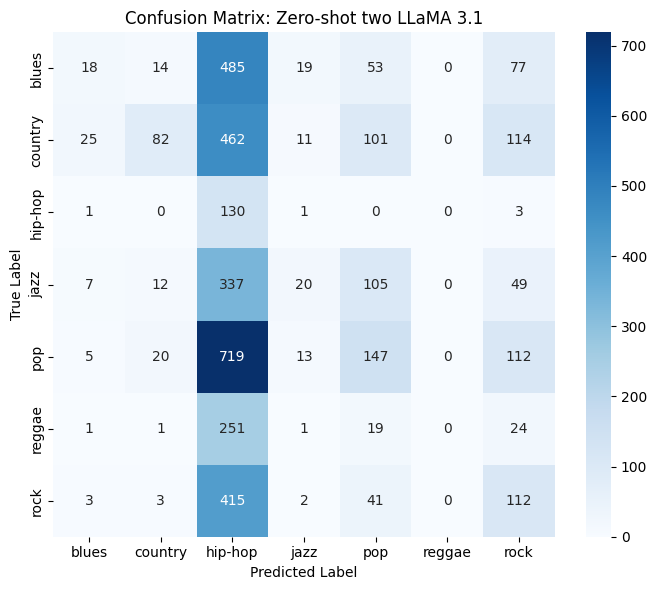

In [ ]:
true_zero = [r['true_genre'] for r in results_zero_test]
pred_zero= [r['predicted_genre'] for r in results_zero_test]

evaluate_genre_predictions(
    true_zero,
    pred_zero,
    folder="llama/",
    file_name="results_no_metadata_llama",
    labels=genres,
    description = "Zero-shot two"
    )

**Testset on zero-shot with Lyrics + year**

In [ ]:
results_zero_year_test = classify_lyrics_bulk(
    song_bulk=df_test,
    show_output=False,
    dance=None,
    year=True,
    description="Test Evaluation - Lyrics + Year"
)

Test Evaluation - Lyrics + Year Prompting:   0%|          | 0/4181 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Test Evaluation - Lyrics + Year Prompting: 100%|██████████| 4181/4181 [07:37<00:00,  9.13it/s]



Test Accuracy: 0.1691
Classification Report:

              precision    recall  f1-score   support

       blues       0.30      0.04      0.06       676
     country       0.63      0.08      0.14       810
     hip-hop       0.08      0.92      0.15       135
        jazz       0.38      0.07      0.11       553
         pop       0.32      0.16      0.21      1044
      reggae       0.00      0.00      0.00       371
        rock       0.17      0.50      0.25       592

   micro avg       0.17      0.17      0.17      4181
   macro avg       0.27      0.25      0.13      4181
weighted avg       0.33      0.17      0.15      4181



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Saved] Test results saved to: run_results/results/llama/results_year_llama


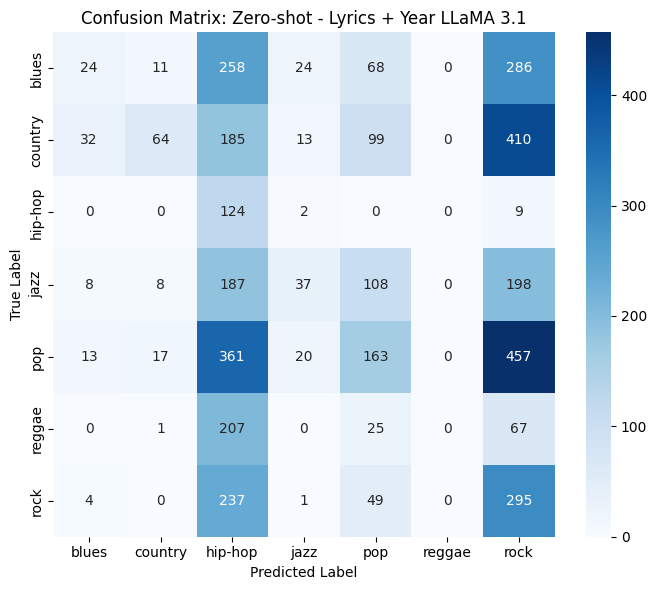

In [ ]:
true_zero_year = [r['true_genre'] for r in results_zero_year_test]
pred_zero_year = [r['predicted_genre'] for r in results_zero_year_test]

evaluate_genre_predictions(
    true_zero_year,
    pred_zero_year,
    folder="llama/",
    file_name="results_year_llama",
    labels=genres,
    description = "Zero-shot - Lyrics + Year"
    )

**Testset on zero-shot with Lyrics + dancability**

In [ ]:
results_zero_dance_test = classify_lyrics_bulk(
    song_bulk=df_test,
    show_output=False,
    dance=True,
    year=None,
    description="Test Evaluation - Lyrics + Danceability"
)

Test Evaluation - Lyrics + Danceability Prompting:   0%|          | 0/4181 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Test Evaluation - Lyrics + Danceability Prompting: 100%|██████████| 4181/4181 [08:02<00:00,  8.67it/s]



Test Accuracy: 0.1557
Classification Report:

              precision    recall  f1-score   support

       blues       0.35      0.02      0.03       676
     country       0.65      0.05      0.09       810
     hip-hop       0.06      0.95      0.11       135
        jazz       0.33      0.03      0.06       553
         pop       0.29      0.34      0.32      1044
      reggae       0.00      0.00      0.00       371
        rock       0.23      0.16      0.19       592

   micro avg       0.16      0.16      0.16      4181
   macro avg       0.27      0.22      0.11      4181
weighted avg       0.33      0.16      0.14      4181



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Saved] Test results saved to: run_results/results/llama/results_dance_llama


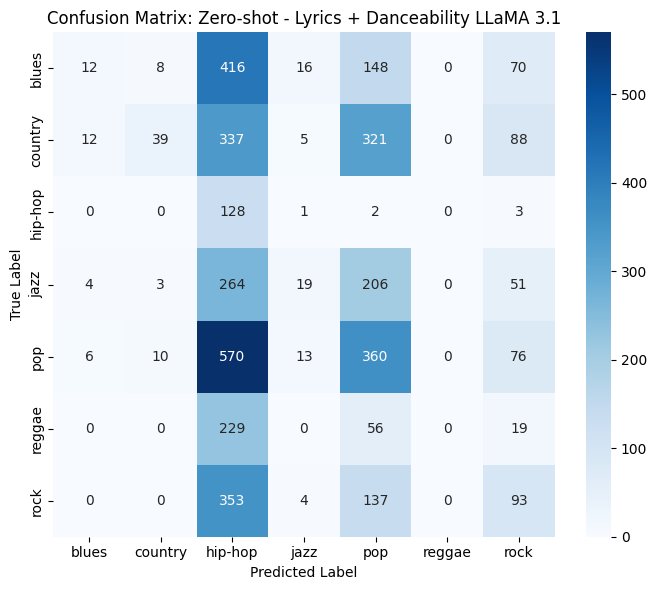

In [ ]:
true_zero_dance = [r['true_genre'] for r in results_zero_dance_test]
pred_zero_dance = [r['predicted_genre'] for r in results_zero_dance_test]

evaluate_genre_predictions(
    true_zero_dance,
    pred_zero_dance,
    folder="llama/",
    file_name="results_dance_llama",
    labels=genres,
    description = "Zero-shot - Lyrics + Danceability"
    )

**Testset on zero-shot with Lyrics + year and dancability**

In [ ]:
results_zero__year_dance_test = classify_lyrics_bulk(
    song_bulk=df_test,
    show_output=False,
    dance=True,
    year=True,
    description="Test Evaluation - Lyrics + year + Danceability"
)

Test Evaluation - Lyrics + year + Danceability Prompting:   0%|          | 0/4181 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Test Evaluation - Lyrics + year + Danceability Prompting: 100%|██████████| 4181/4181 [08:26<00:00,  8.25it/s]



Test Accuracy: 0.1708
Classification Report:

              precision    recall  f1-score   support

       blues       0.33      0.03      0.05       676
     country       0.61      0.07      0.12       810
     hip-hop       0.08      0.93      0.15       135
        jazz       0.36      0.06      0.10       553
         pop       0.27      0.23      0.25      1044
      reggae       0.00      0.00      0.00       371
        rock       0.18      0.43      0.25       592

   micro avg       0.18      0.17      0.17      4181
   macro avg       0.26      0.25      0.13      4181
weighted avg       0.31      0.17      0.15      4181



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Saved] Test results saved to: run_results/results/llama/results_both_llama


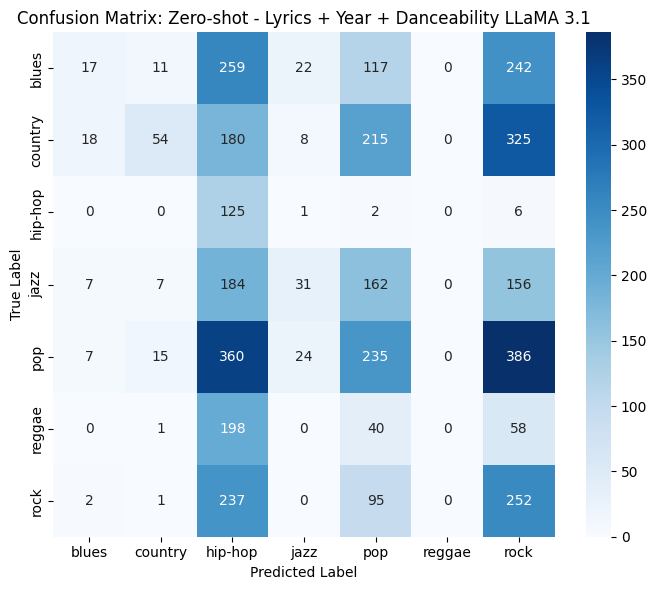

In [ ]:
true_zero_year_dance = [r['true_genre'] for r in results_zero__year_dance_test]
pred_zero_year_dance = [r['predicted_genre'] for r in results_zero__year_dance_test]

evaluate_genre_predictions(
    true_zero_year_dance,
    pred_zero_year_dance,
    folder="llama/",
    file_name="results_both_llama",
    labels=genres,
    description = "Zero-shot - Lyrics + Year + Danceability")